# **LAB 2: PROBLEM OPTYMALIZACJI, SYMULACJA WYŻARZANIA - ADRIAN GLANOWSKI**

Importy:

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import make_blobs
from copy import copy, deepcopy
from PIL import Image


import networkx as nx



## **Problem komiwojażera**

Rozważamy typowy problem komiwojażera, rozpoczynamy od losowej kolejności odwiedzania miast. Żeby odnaleźć inne rozwiązania zamieniamy kolejnością dwa dowolne miasta. Jeśli odległość do przebycia w takim przypadku jest mniejsza niż w poprzednim, to akceptujemy to rozwiązanie. Jeśli nowe rozwiązanie jest gorsze, to jest szansa, że jest zaakceptujemy, zależna od liczby wykonanych iteracji.

Rozwiązanie rozważymy dla następujących dystrybucji punktów:
- punkty generowane rozkładem jednorodnym
- punkty generowane rozkładem normalnym
- punkty generowane w 4 grupach
- punkty generowane w 9 grupach

Obliczenia wykonamy dla dwóch sposobów zamiany kolejności miast:
- zamiana dwóch kolejnych punktów
- zamiana dwóch dowolnych punktów (nazywana przeze mnie też jako bigswitch - nazwa wynika z prawdziwości przekazania argumentu algorytmu o tej nazwie)

### **Generowanie punktów**

Rozkład jednorodny

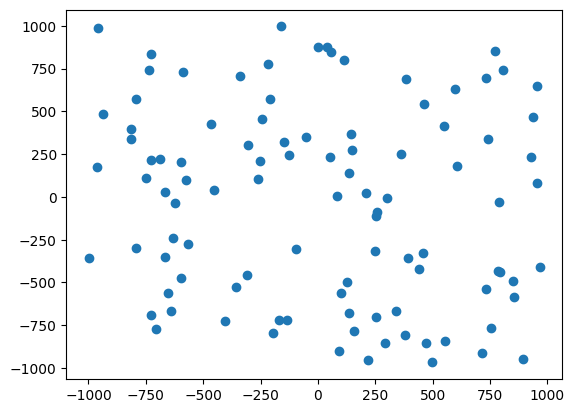

In [52]:
def uniform_distribution(n, lower = -1000.0, upper = 1000.0):
    return np.random.uniform(lower, upper, (n, 2))

points = uniform_distribution(100)
plt.scatter(points[:, 0], points[:, 1])  
plt.show()

Rozkład normalny

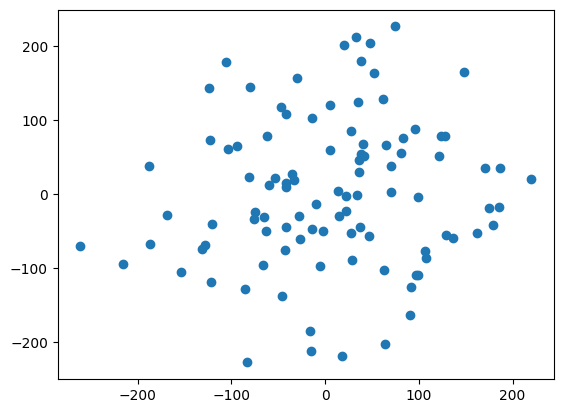

In [53]:
def normal_distribution(n, exp = 0, std = 100):
    return np.random.normal(exp, std, (n, 2))

points = normal_distribution(100)
plt.scatter(points[:, 0], points[:, 1])  
plt.show()

Rozkład klastrowy

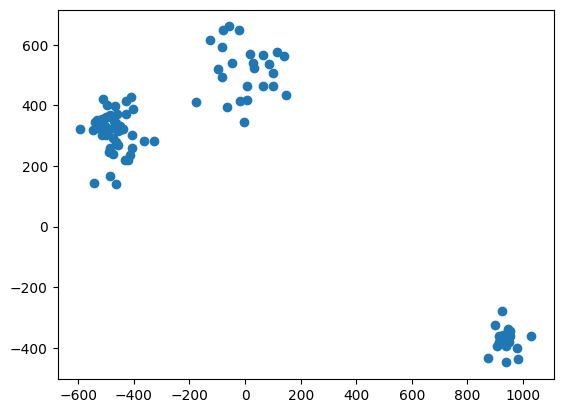

In [54]:
def cluster_distribution(n, k, lower=-1000.0, upper=1000.0):
    if k > n:
        raise ValueError("Number of clusters cannot be greater than number of points")
    
    centers = [(np.random.uniform(lower, upper), np.random.uniform(lower, upper)) for _ in range(k)]
    
    cluster_std = [np.random.uniform(0, 100) for _ in range(k)]
    
    points, _ = make_blobs(n_samples=n, centers=centers, cluster_std=cluster_std, n_features=2)
    
    return points

points = cluster_distribution(100, 4)
plt.scatter(points[:, 0], points[:, 1])  
plt.show()

Punkty na okręgu

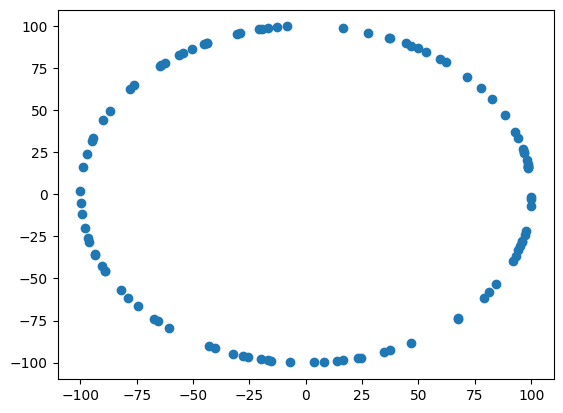

In [55]:
def circle_distribution(n, O = (0,0), R = 100):
    points = [0]*n
    for i in range(n):
        angle = np.random.uniform(0, 360)*np.pi/180
        points[i] = (O[0] + R*np.cos(angle), O[1] + R*np.sin(angle))
    return np.array(points).reshape((n, 2))

points = circle_distribution(100)
plt.scatter(points[:, 0], points[:, 1])  
plt.show()

### **Główny algorytm**

Algorytm TSP przyjmujący punkty, hiperparametry, flagę decydującą o sposobie zamiany kolejności oraz minimalne znaczące prawdopodobieństwo. Kończy się w przypadku wykonania założonej liczby iteracji (równej liczbie punktów) bez znalezienia lepszego stanu.

In [59]:
def TSP(points, T0 = 100, B=0.999, big_switch = True, eps = 1e-36):
    if T0 < 0 or B < 0:
        raise ValueError

    def distance(point1, point2):
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    
    def total_path(points):
        sum_path = 0
        for i in range(n):
            sum_path += distance(points[i], points[(i-1)%n])

        return sum_path

    def temperature(T0, B, k):
        temp = T0*B**k
        return temp if temp > 0 else eps

    n = len(points)
    
    #wykres watości od iteracji
    values = []
    args = []

    #wykres prawdopodobieństwa od iteracji
    probs = []
    prob_args = []

    #kolejne klatki algorytmu
    frames = []

    best_path = points
    sum_path = total_path(points)
    values.append(sum_path)
    args.append(0)
    
    best_pair = [0, sum_path]
    prob_usage = 1
    k = 1
    worse_cnt = 0

    while True:
        if big_switch:
            index1 = np.random.randint(0, n)
            index2 = np.random.randint(0, n)
            while index1 == index2:
                index1 = np.random.randint(0, n)
                index2 = np.random.randint(0, n)
            points[[index1, index2]] = points[[index2, index1]]
            
        else:
            index = np.random.randint(1, n)
            points[[index-1, index]] = points[[index, index-1]]
        
        new_sum_path = total_path(points)
        frames.append(copy(points))
        
        if new_sum_path < sum_path:
            values.append(new_sum_path)
            args.append(k)

            if new_sum_path < best_pair[1]:
                best_pair = [k, new_sum_path]
                best_path = deepcopy(points)
                worse_cnt = 0
                
            sum_path = new_sum_path
                
        else:
            temp = temperature(T0, B, k)
            
            prob = np.exp(-1/temp)
            probs.append(prob)
            prob_args.append(prob_usage)

            prob_usage += 1


            if prob < np.random.rand():
                if big_switch:
                    points[[index1, index2]] = points[[index2, index1]]
                else:
                    points[[index-1, index]] = points[[index, index-1]]

                if prob <= eps:  
                    worse_cnt += 1
                    if worse_cnt == n:
                        break
                
            else:
                values.append(new_sum_path)
                args.append(k)
                sum_path = new_sum_path
        k += 1
    
    return args, values, prob_args, probs, best_pair, best_path, frames

Generator gifów do TSP, wygenerowane przeze mnie gify znajdują się w folderze binary_gif. Szablon wygenerowanych gifów to *nazwa_rozkładu(_bigswitch)?(_fast)?*, co znaczy, że nazwa rozkładu pojawia się zawsze oraz dodatkowe oznaczenia czy algorytm używa kolejnych zmian czy dowolnych (bigswitch) oraz czy gif został wygenerowany wyświetlając 3 klatki na sekundę czy 15.

In [60]:
def make_gif(name, paths, big_switch):
    fig, ax = plt.subplots(figsize=(12, 12))

    def init():
        ax.clear()
        ax.set_title("TSP Optimization Progress")


    def update(frame):
        ax.clear()
        current_path = paths[frame]
        x = np.append(current_path[:, 0], current_path[0, 0])  # loop back to start
        y = np.append(current_path[:, 1], current_path[0, 1])
        
        ax.plot(x, y, 'b-', lw=2, label=f'Iter {frame}')
        ax.scatter(current_path[:, 0], current_path[:, 1], c='red')
        
        ax.set_title(f"TSP Iteration {frame}")

        ax.legend()

    ani = FuncAnimation(fig, update, frames=len(paths), init_func=init, repeat=False)

    # Save as GIF
    ani.save("TSP_gif/" + name + f"{"big" if big_switch else ""}fast.gif", writer=PillowWriter(fps=15))

Generator wykresów, do którego przekazywane są liczba oczekiwanych wykrsów, analizowane punkty oraz znany już argument bigswitch.

In [61]:
PLOTS_CNT = 3
def draw_n_plots(n, points, big_switch):

    figure, axis = plt.subplots(n, 2, figsize=(15, 6*n))
    for i in range(n):
        args, vals, prob_args, probs, best_pair, best_path, frames = TSP(copy(points), big_switch=big_switch)
        axis[i][0].plot(args, vals, "-")
        axis[i][0].plot(best_pair[0], best_pair[1], "go")
        axis[i][0].set_title("Distance")
        axis[i][0].set_xlabel("Iteration")
        axis[i][0].set_ylabel("Value")
        axis[i][0].legend(title=f"Best value = {best_pair[1]}")
        axis[i][0].set_xlim(left = 0)
        axis[i][0].set_ylim(bottom = 0)

        axis[i][1].plot(prob_args, probs, "o", markersize=0.1)
        axis[i][1].set_title("Probability of accepting worse distance")
        axis[i][1].set_xlabel("Iteration")
        axis[i][1].set_ylabel("Probability")
        axis[i][1].set_xlim(left = 0)
    

    plt.suptitle(f"Using {"global swapping" if big_switch else "local swapping"}")
    plt.show()
    

### **Przykłady**

C:\Users\adria\AppData\Local\Temp\ipykernel_20992\3450112453.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


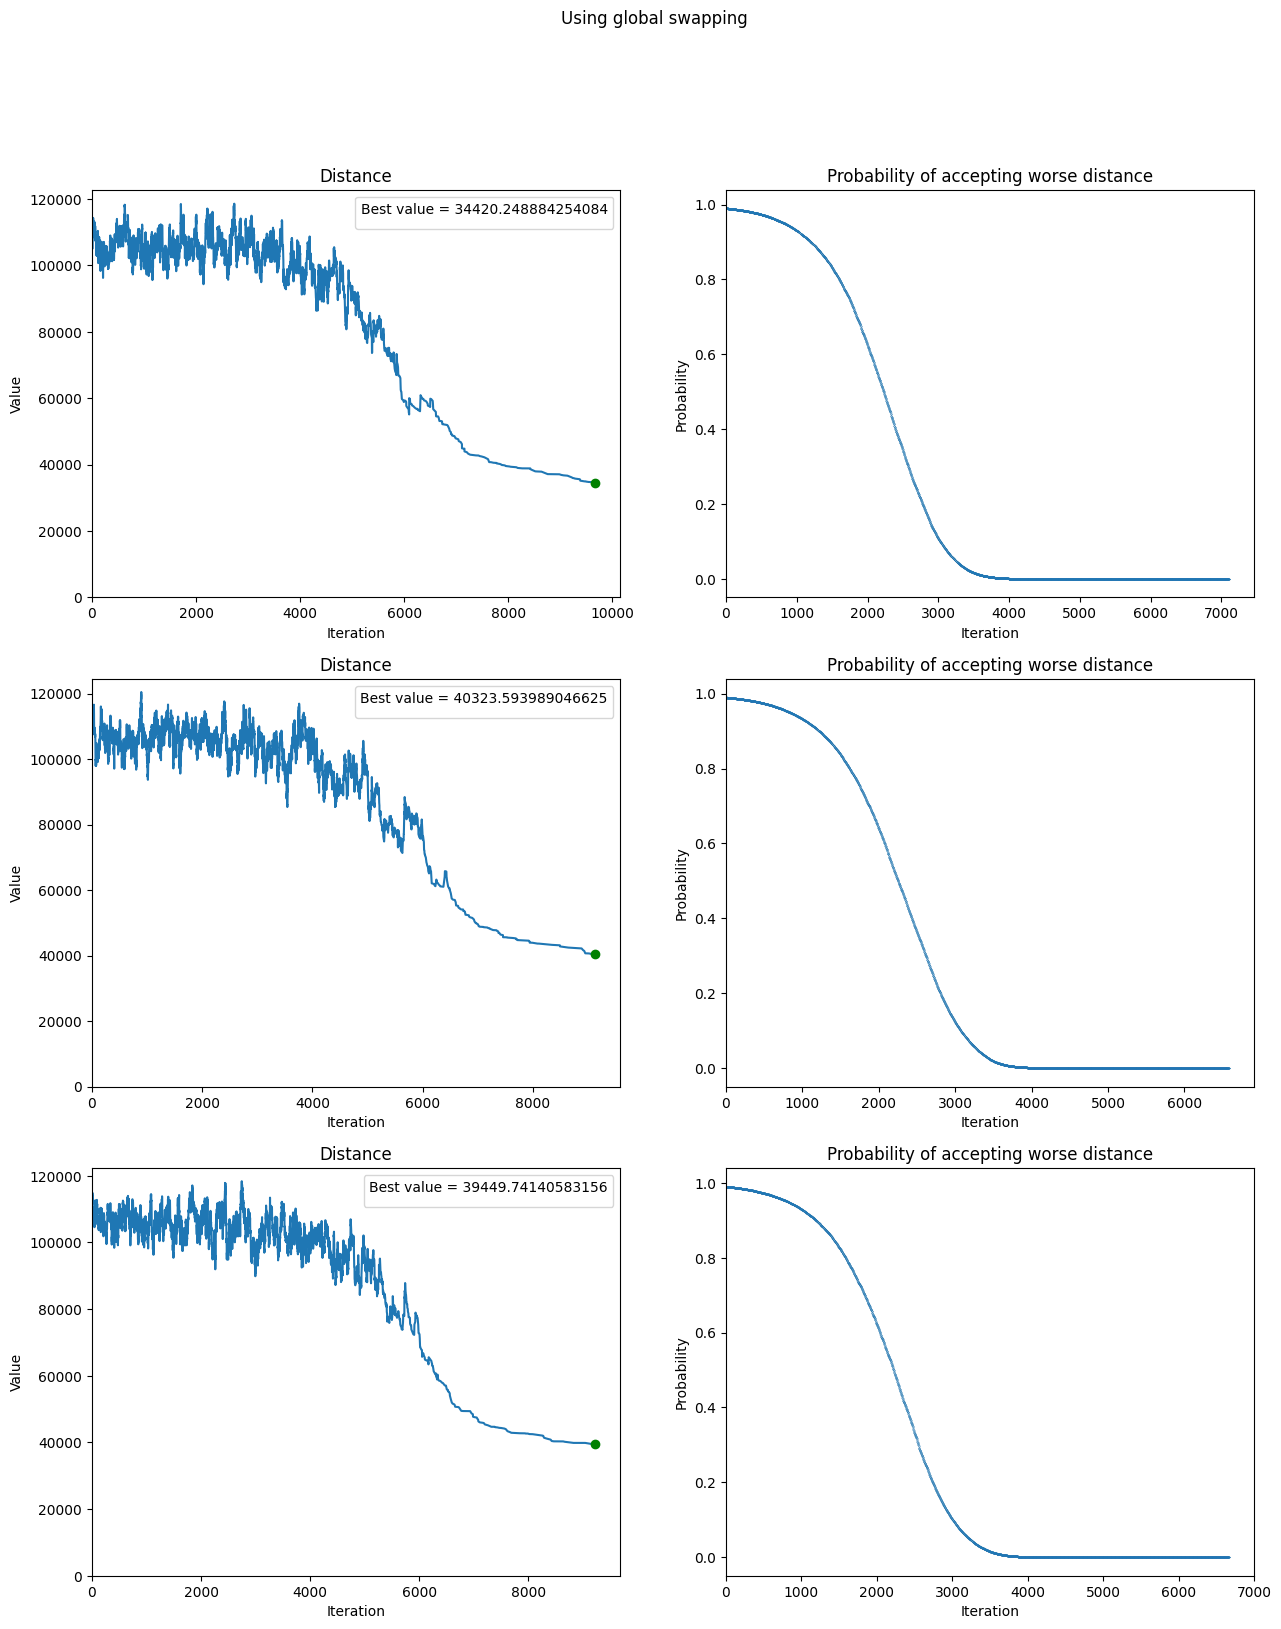

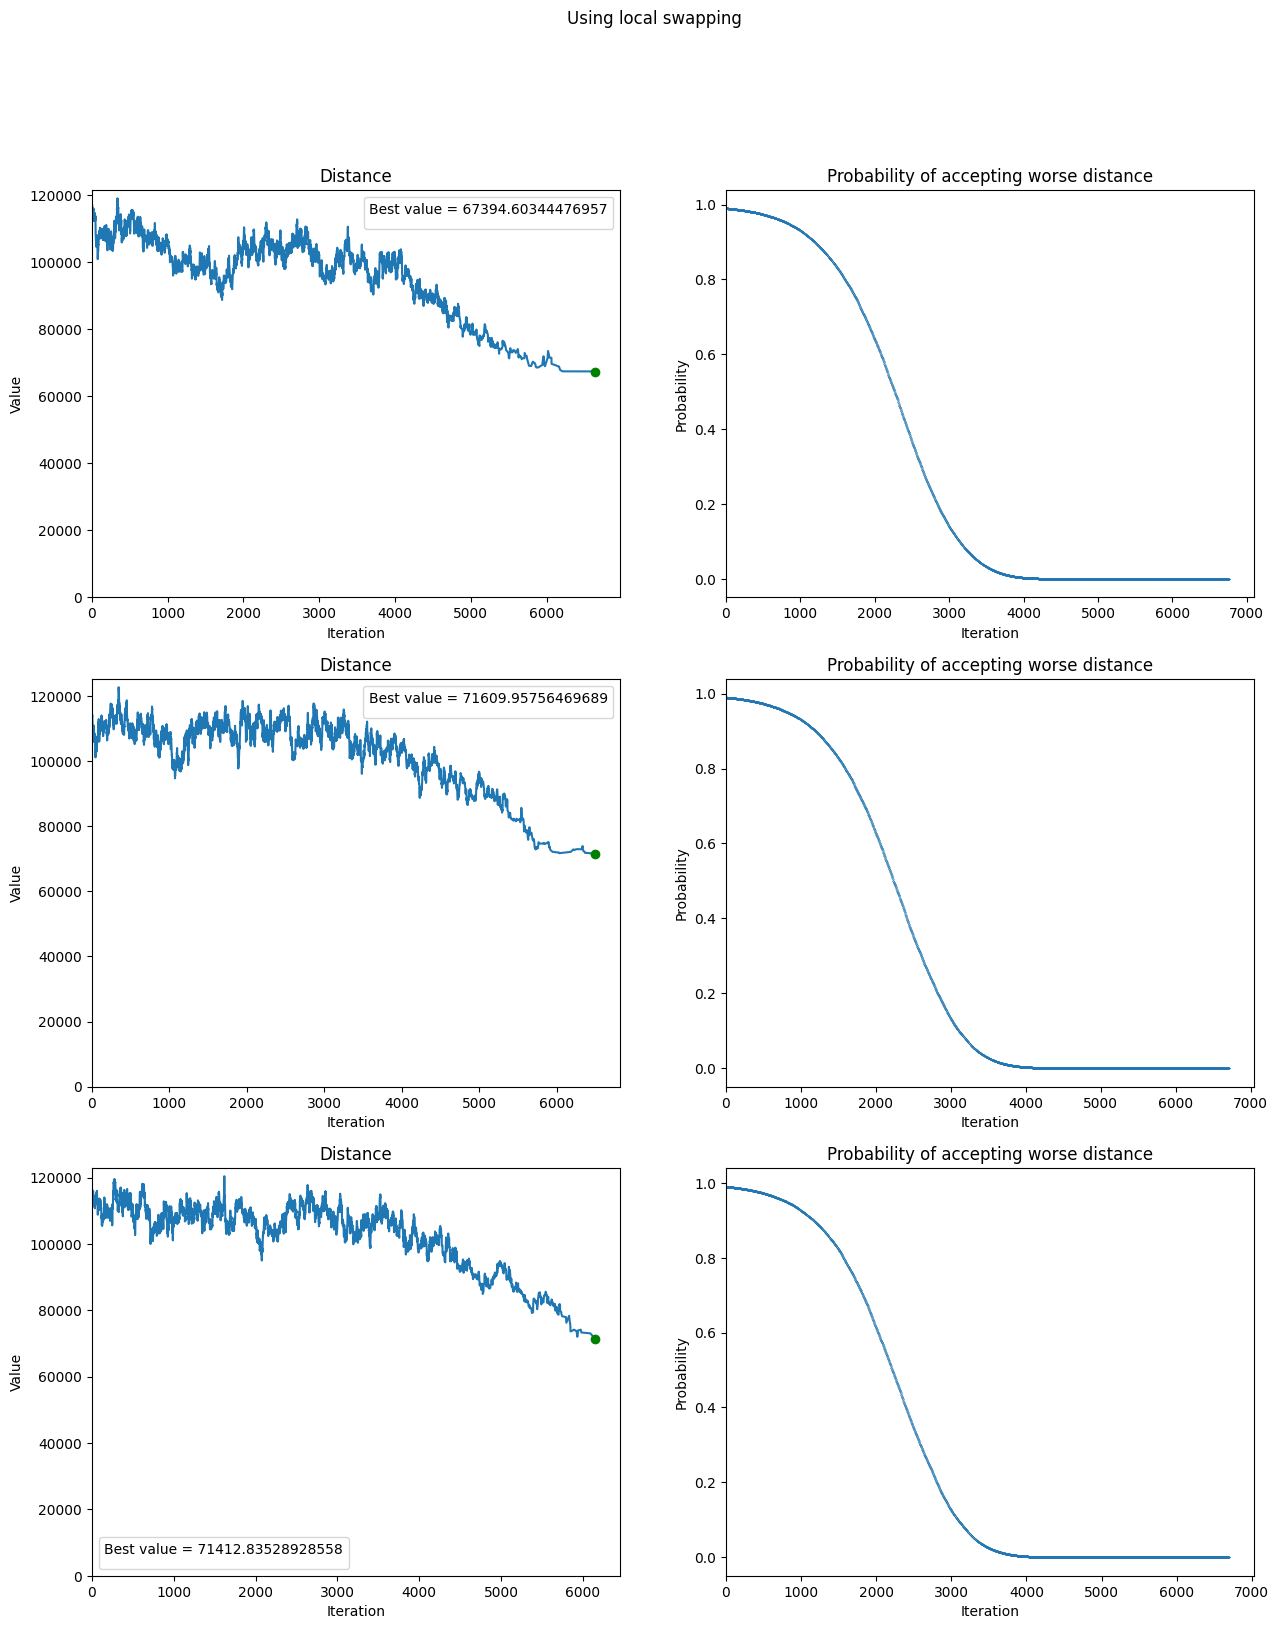

In [62]:
x = uniform_distribution(100)
draw_n_plots(3, x, True)
draw_n_plots(3, x, False)

C:\Users\adria\AppData\Local\Temp\ipykernel_20992\3450112453.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


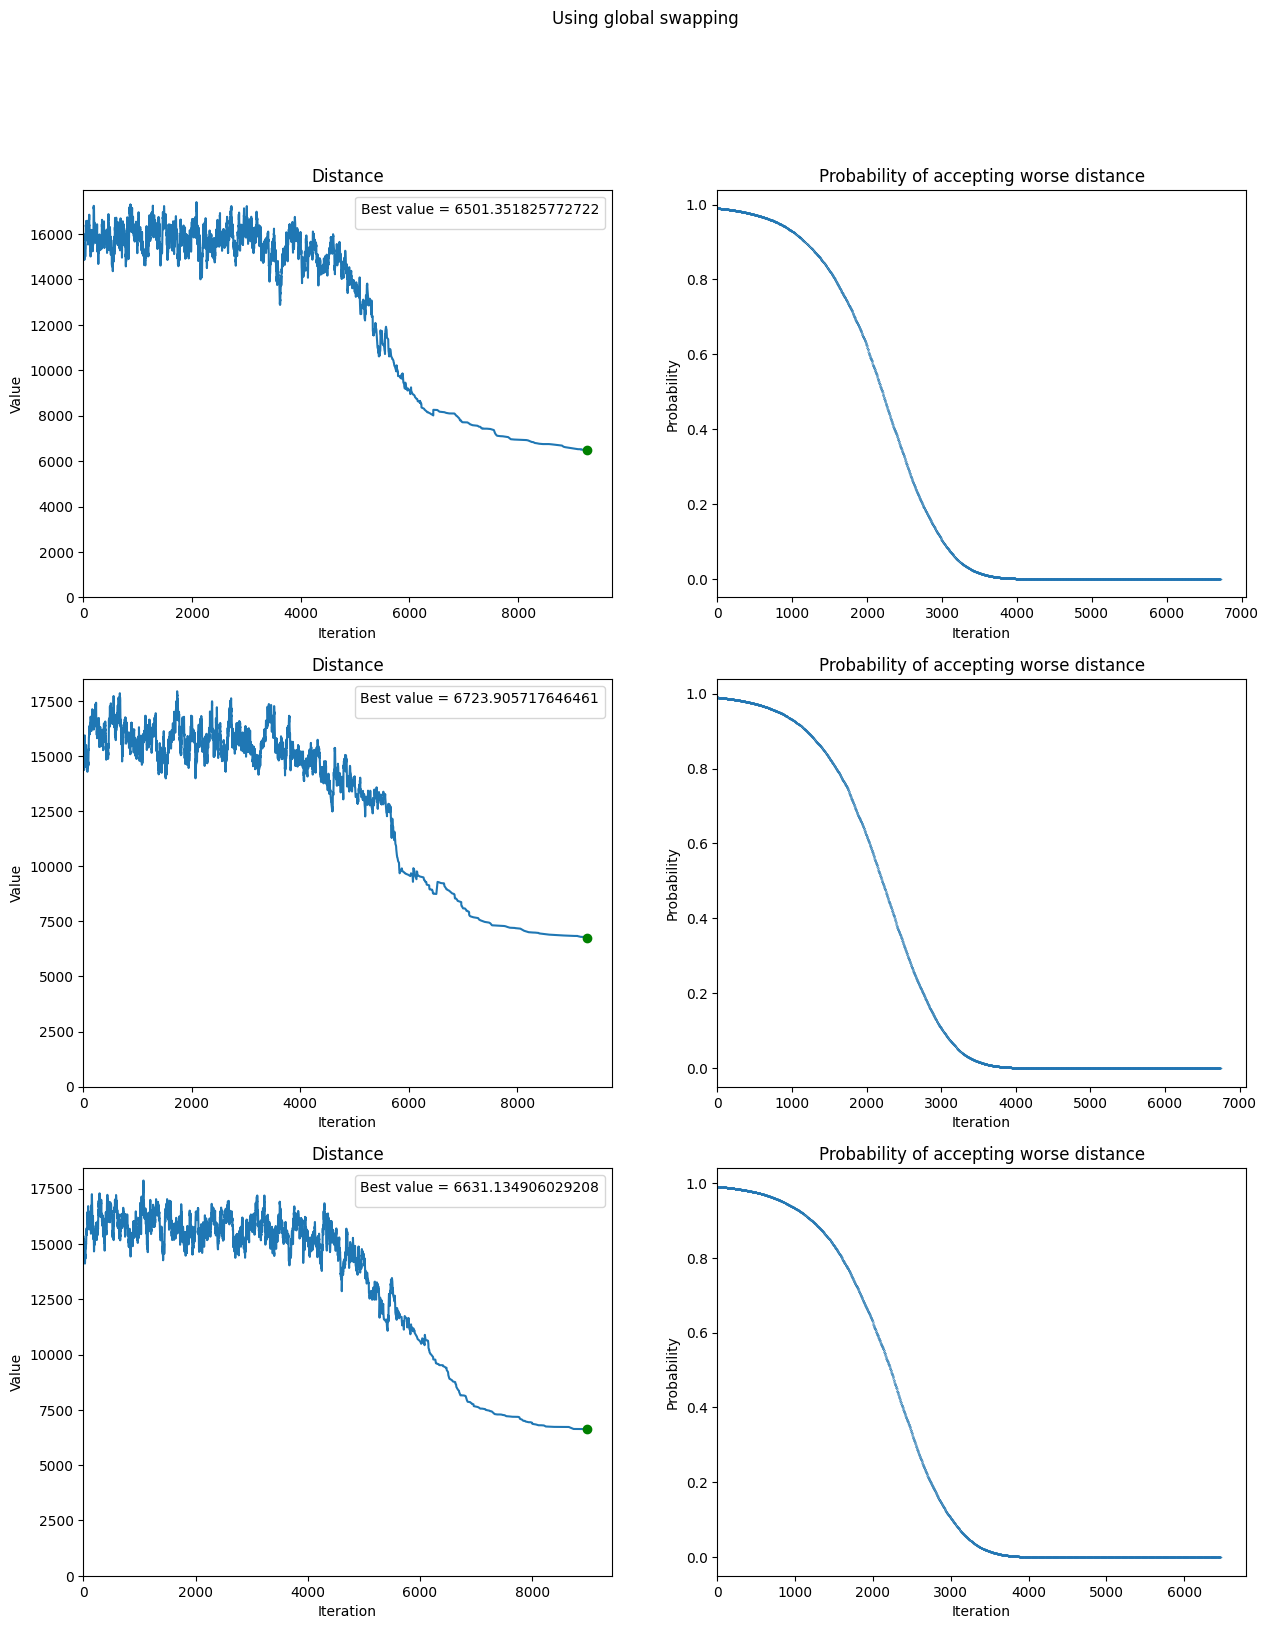

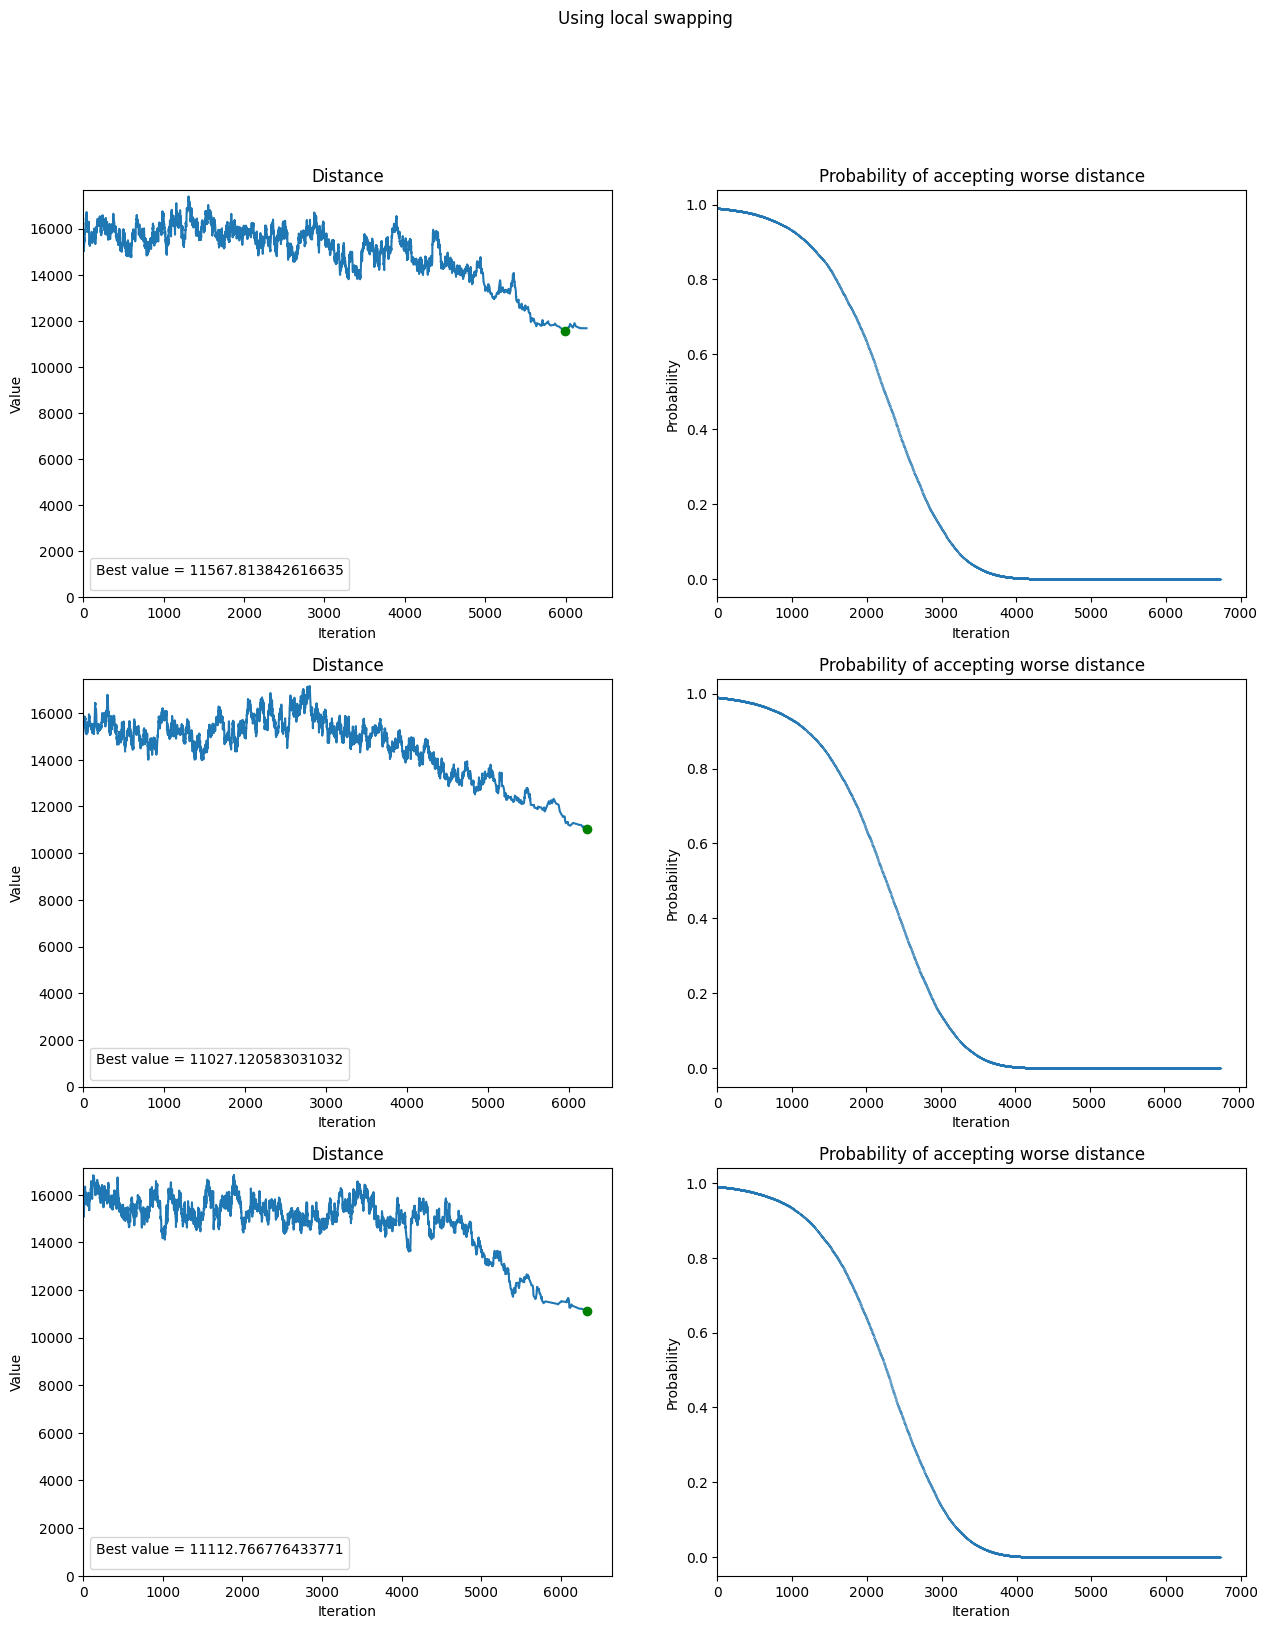

In [63]:
y = normal_distribution(100)
draw_n_plots(3, y, True)
draw_n_plots(3, y, False)

C:\Users\adria\AppData\Local\Temp\ipykernel_20992\3450112453.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


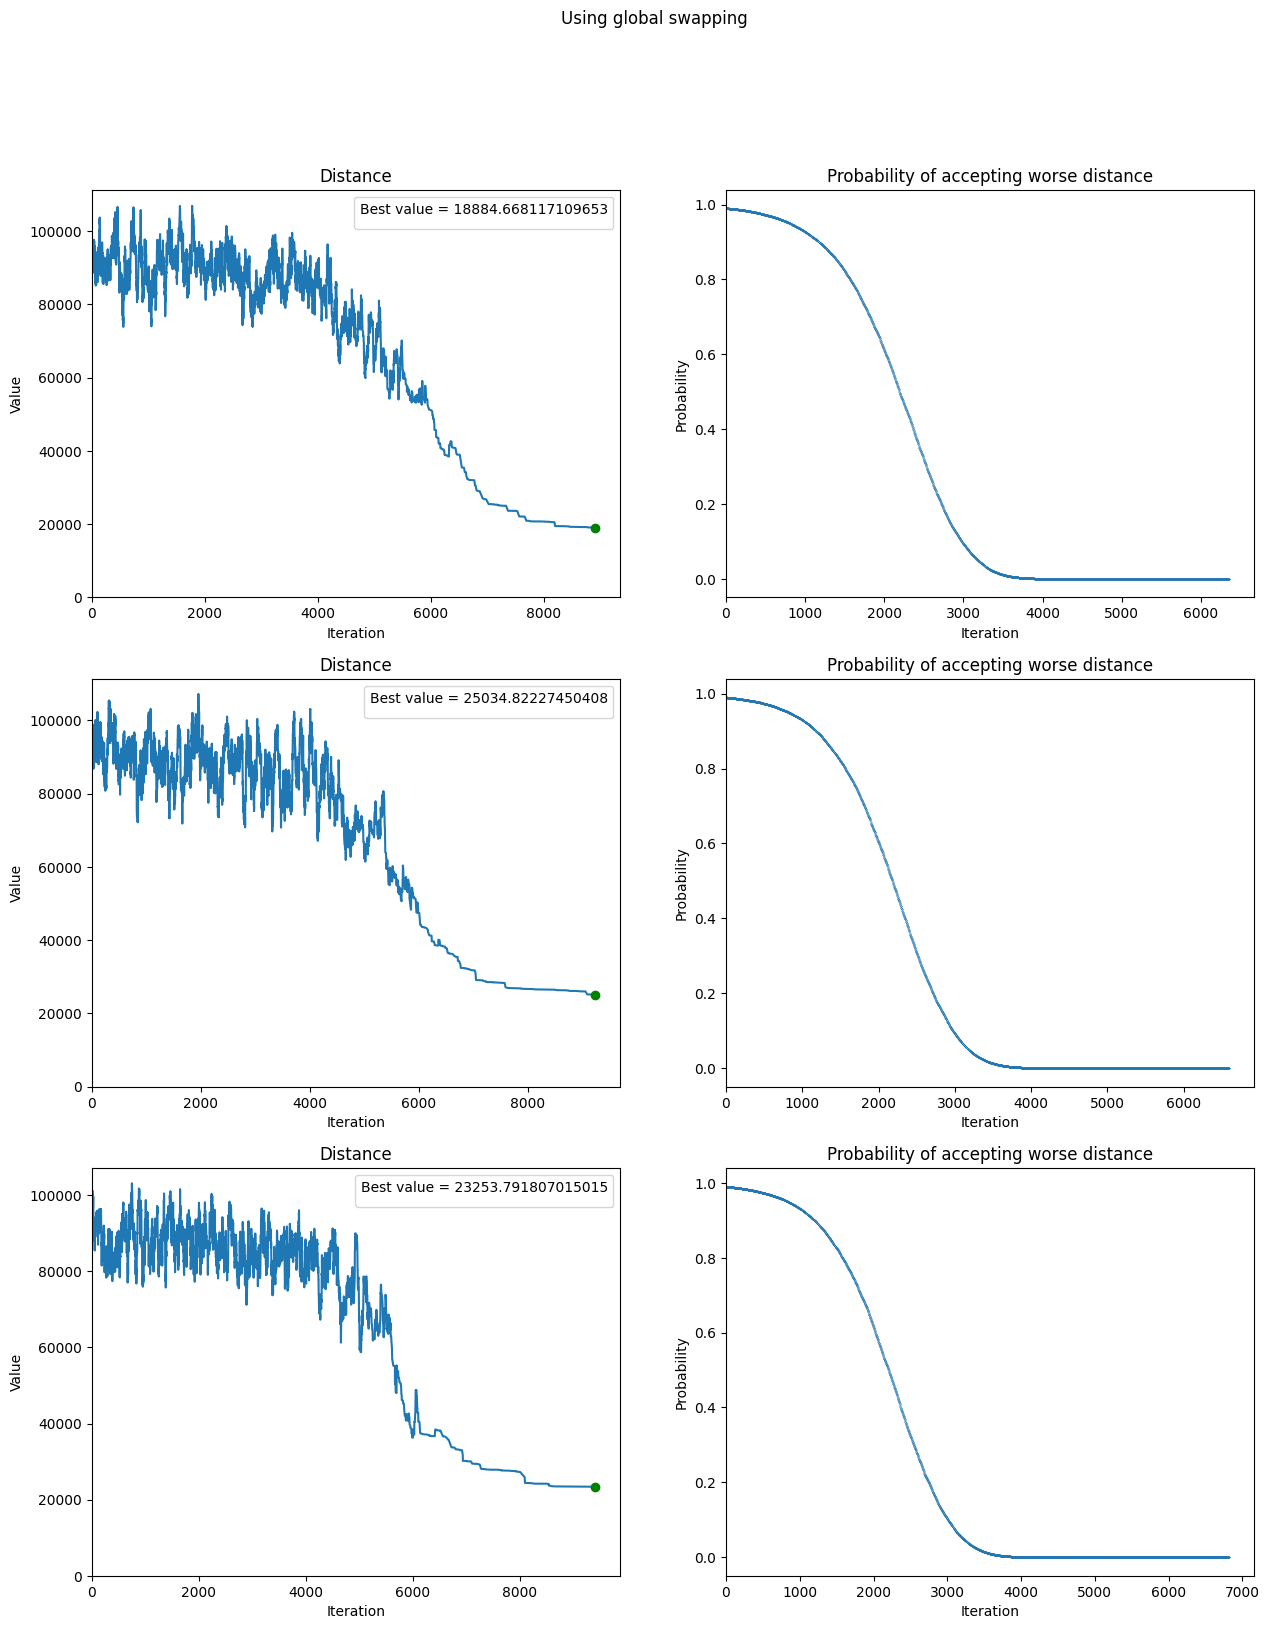

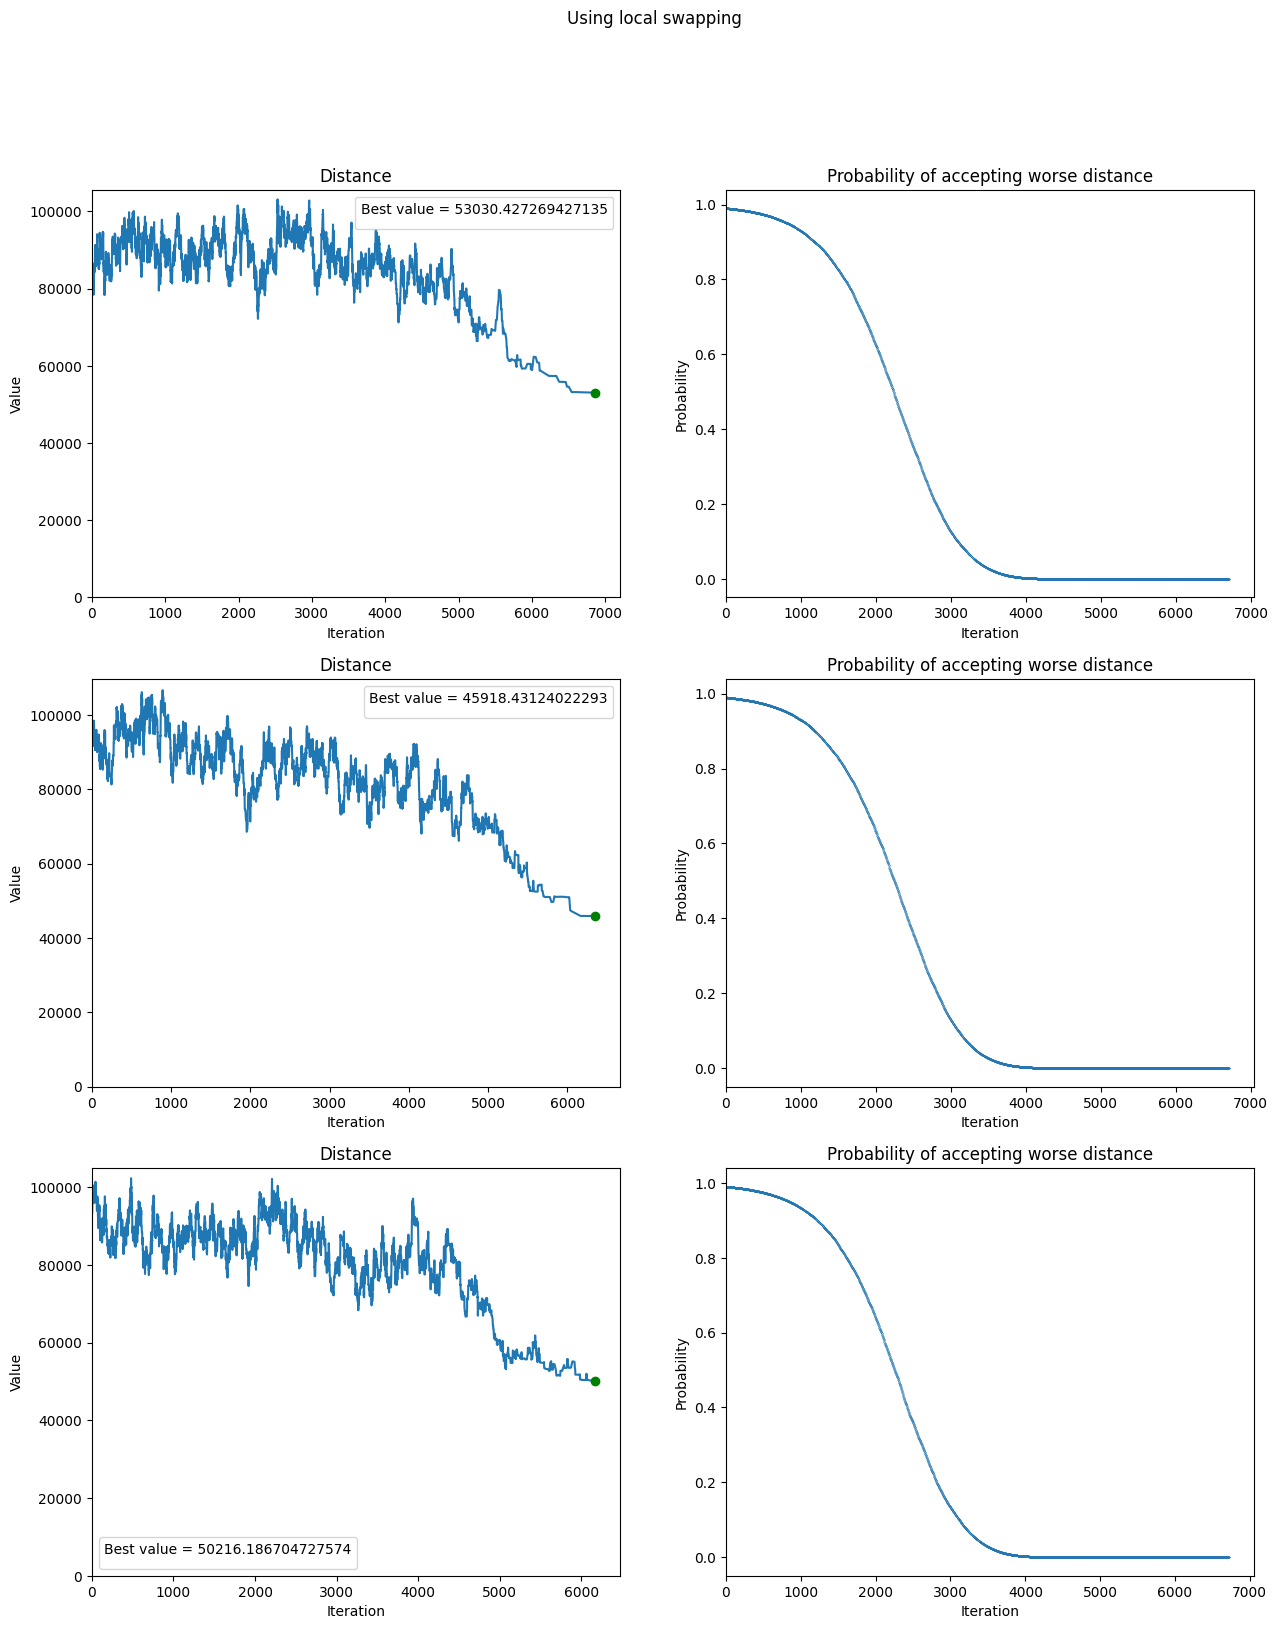

In [64]:
z = cluster_distribution(100, 4)
draw_n_plots(3, z, True)
draw_n_plots(3, z, False)

C:\Users\adria\AppData\Local\Temp\ipykernel_20992\3450112453.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


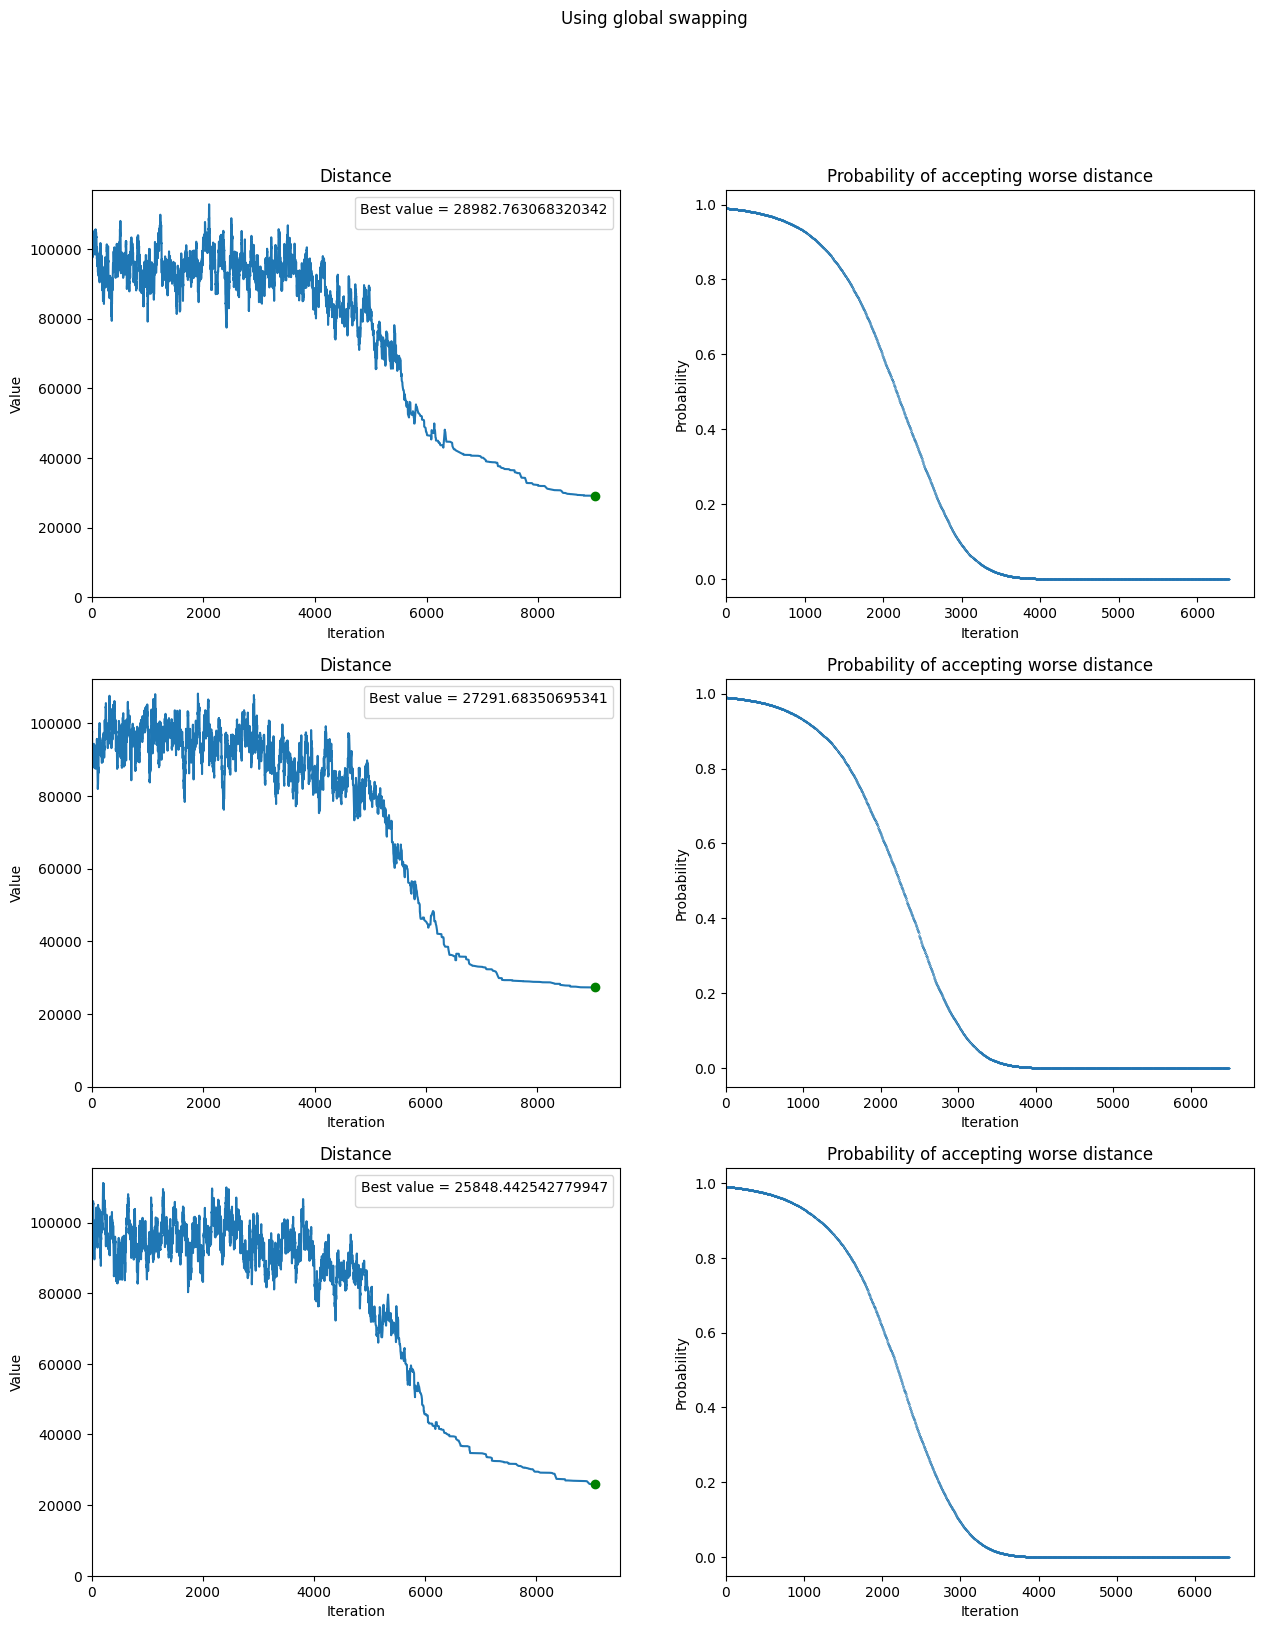

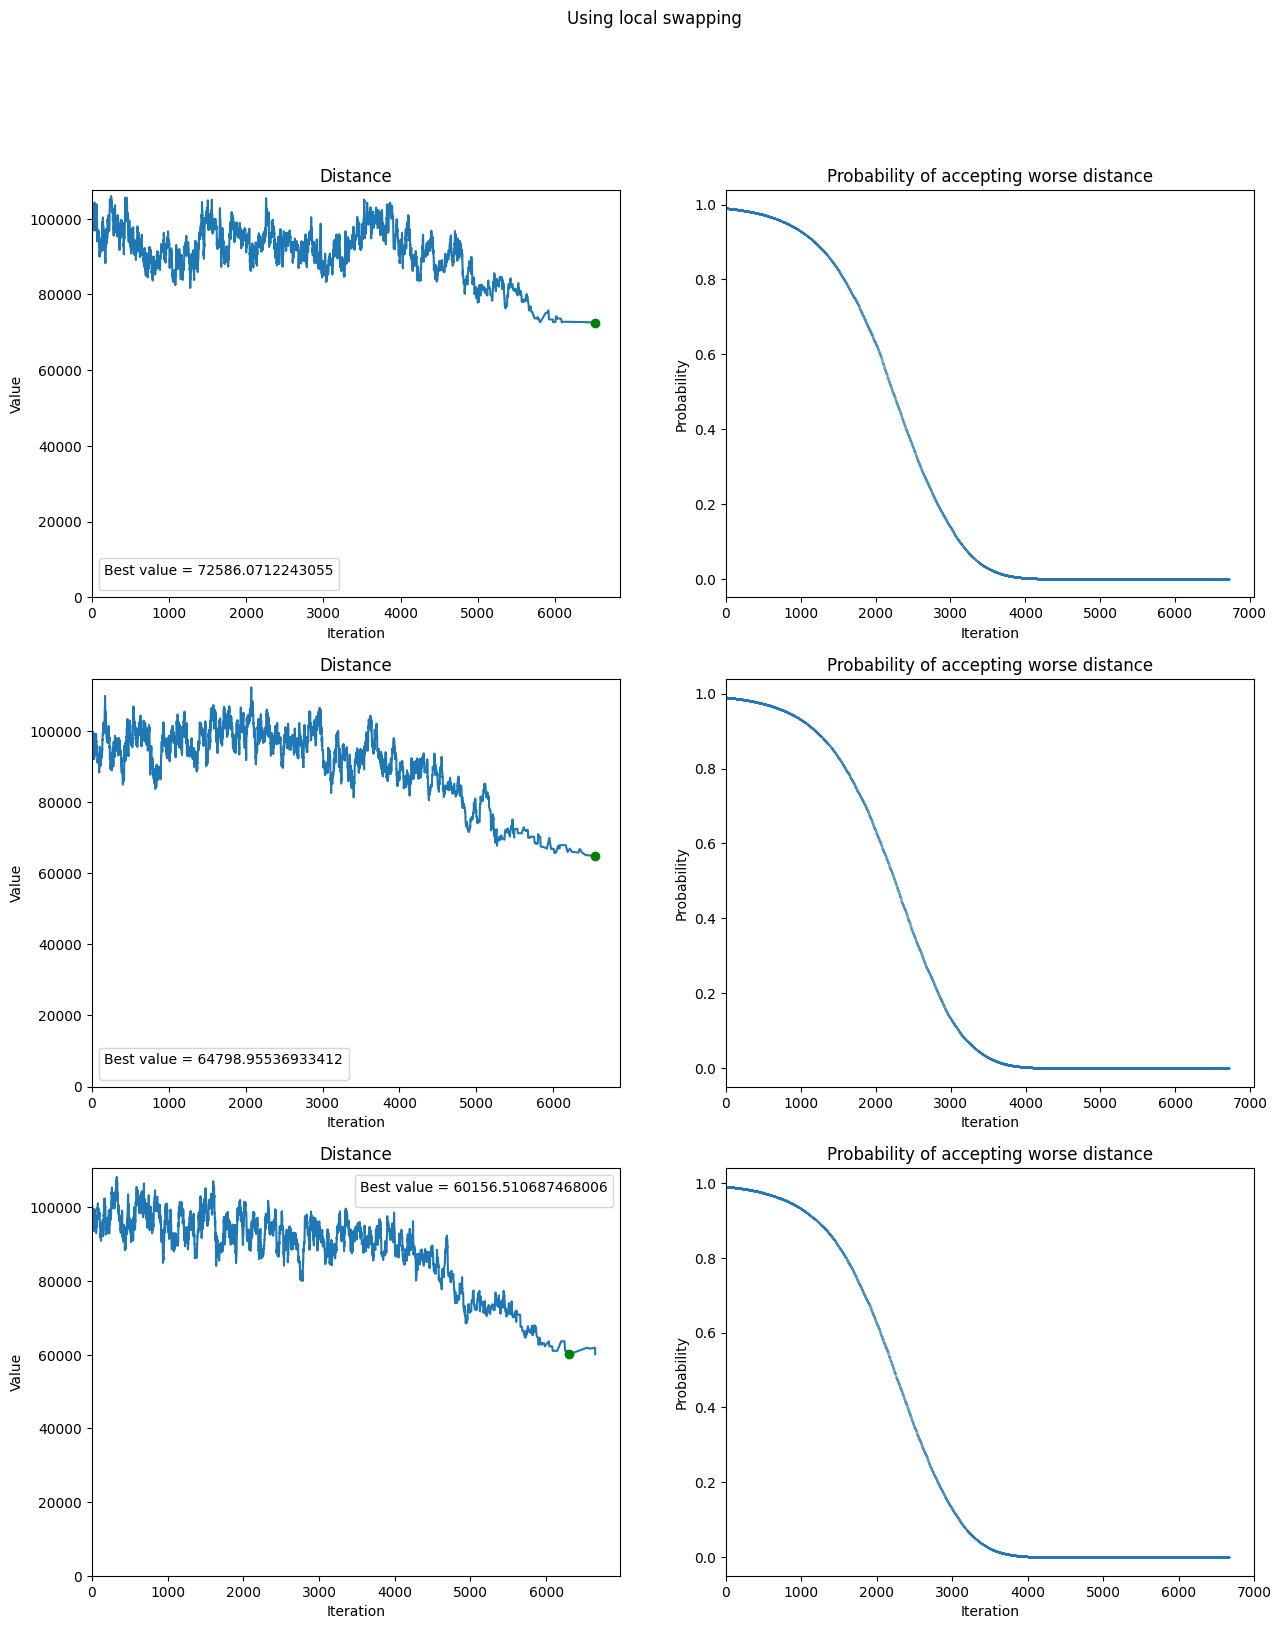

In [65]:
a = cluster_distribution(100, 9)
draw_n_plots(3, a, True)
draw_n_plots(3, a, False)

C:\Users\adria\AppData\Local\Temp\ipykernel_20992\3450112453.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


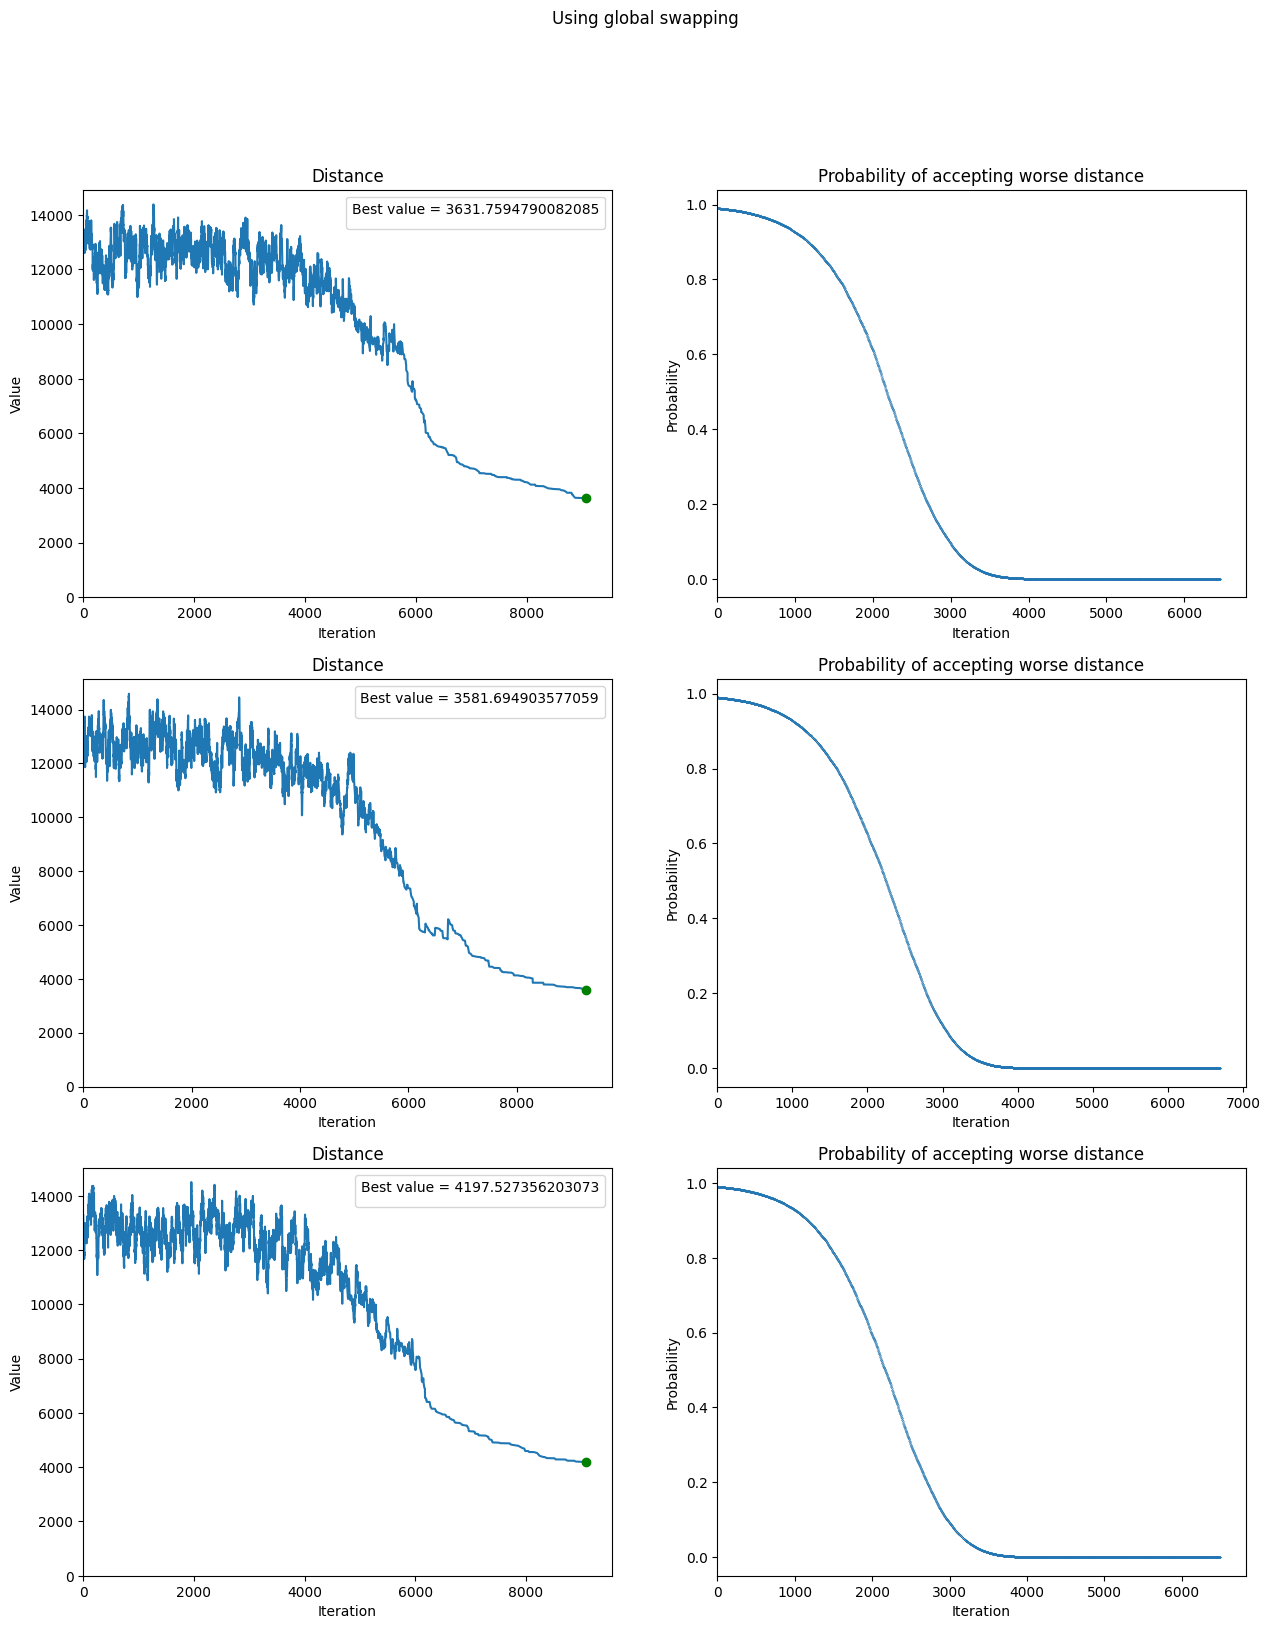

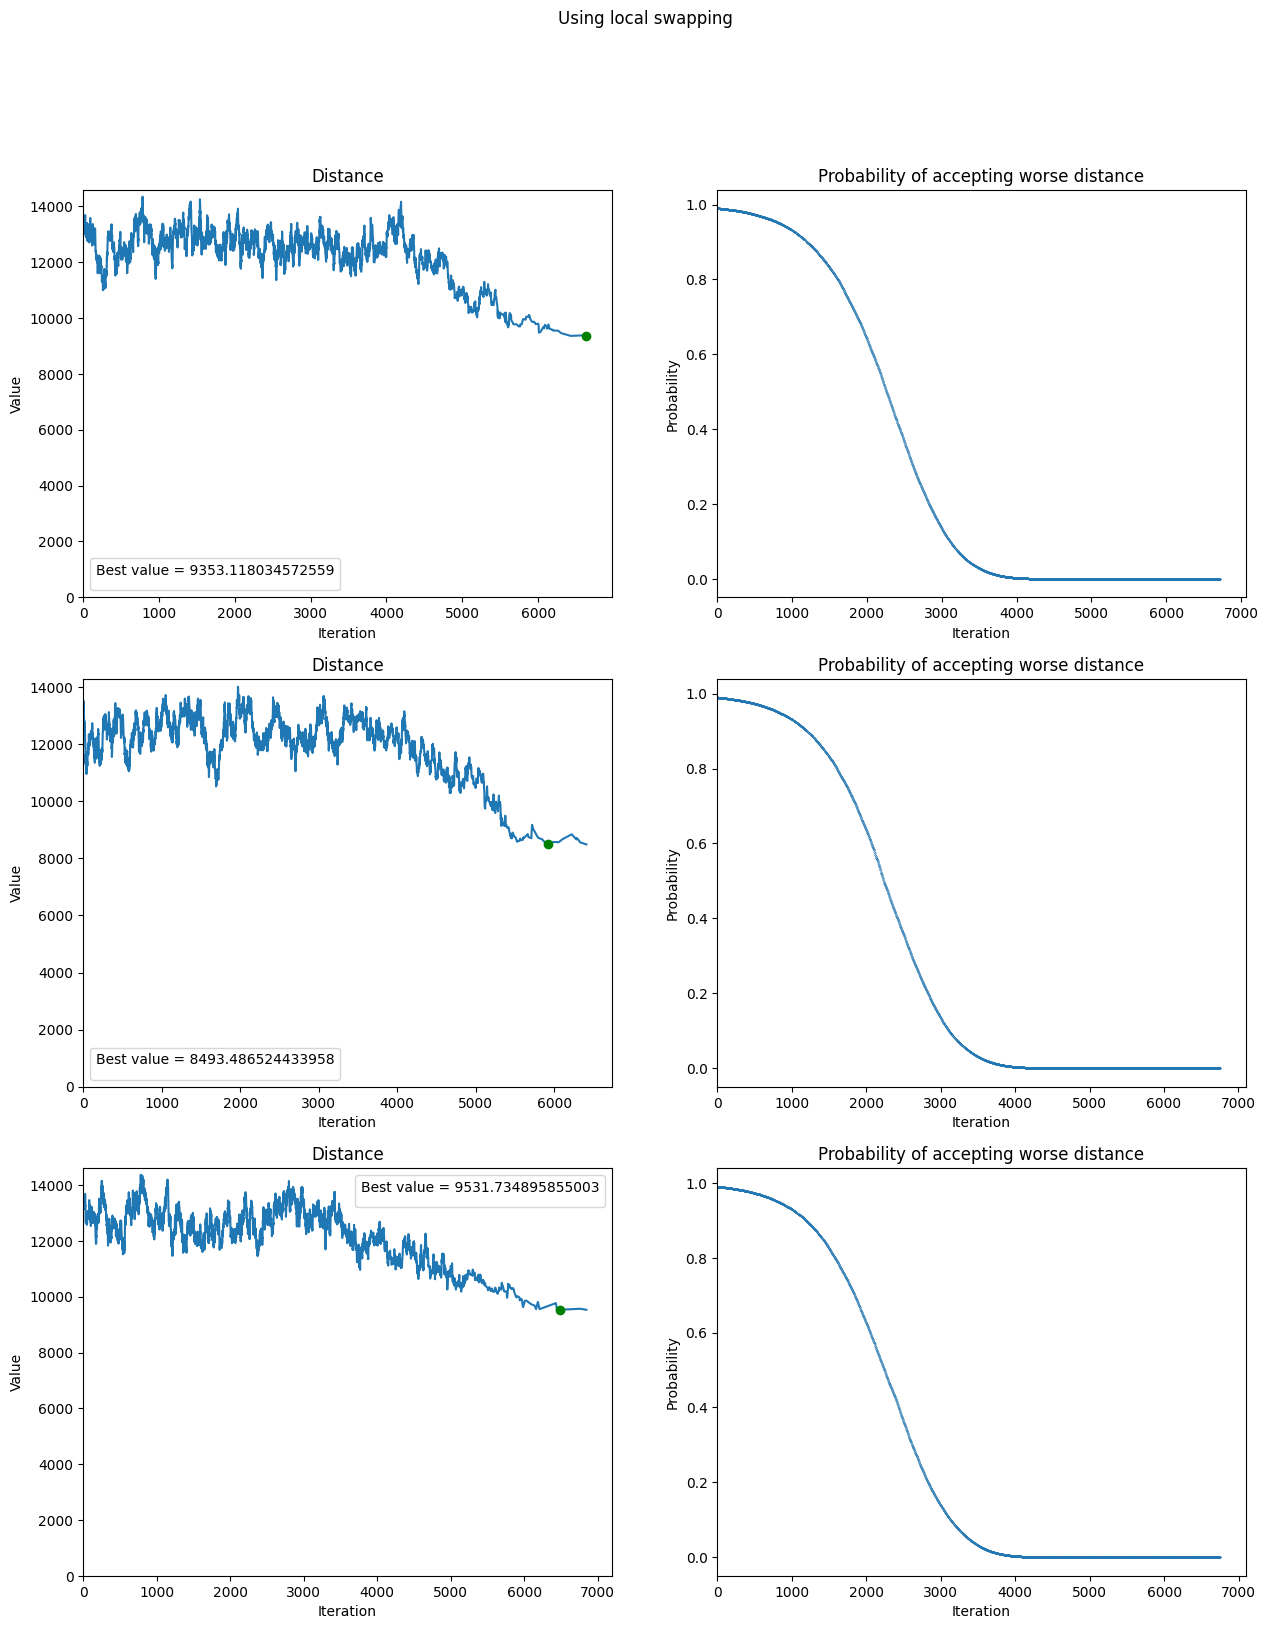

In [66]:
b = circle_distribution(100)
draw_n_plots(3, b, True)
draw_n_plots(3, b, False)

Jak można zauważyć, przy aktualnych hiperparametrach, bigswitch znajduje znacznie lepsze rozwiązania niż zamaiana kolejnych argumentów. Jako że algorytm jest losowy to został wykonany po parę razy, w nadziei otrzymania lepszego rozwiązania. Wiedza o losowości została też zastosowana zapamiętując najlepsze rozwiązanie w danym podejściu 

## **Obraz binarny**

Funkcja oblicza najlepsze rozłożenie wartości -1 i 1 (alternatywnie 0 i 1 lub inne binarne wartości - wymaga to zmiany implementacji) w tablicy biorać pod uwagę minimalizację wartości założonej z góry funkcji energii.

### **Generowanie wyników**


Funkcja przeliczająca wartość z tablicy na kolor piksela, 0 lub 255, co znaczy czarny lub biały.

In [2]:
def display_values(array):
    return ((array + 1)*0.5*255).astype(np.uint8)

Funkcja przygotowująca tablicę, -1 oznacza piksele, które będą czarne, natomiast 1 oznacza piksele, które będą białe. Piksele białe losujemy z prawdopodobieństwem delta, natomiast czarne z prawdopodobieństwem 1-delta

In [ ]:
def pos_neg(n, delta=0.5):
    return np.random.choice([-1, 1], size=(n, n), p=[1 - delta, delta])


Algorytm rozwiązujący problem dla typowego modelu Isinga.

In [27]:
def Ising_model_neigh(array, neighbours=[(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)], B=0.3):
    
    def update(array, x, y, B):
        n = len(array)
        total = 0
        for j, i in neighbours:
            if n > y + j >= 0 and n > x + i >= 0:
                total += array[y + j, x + i] 
        dE = 2 * array[y, x] * total
        if dE <= 0:
            array[y, x] *= -1
        elif np.exp(-dE*B) > np.random.rand():
            array[y, x] *= -1


    n = len(array)
    for j in range(n):
        for i in range(n):
            update(array, i, j, B)
    return array


Algorytm, który preferuje generowanie pionowych lub poziomych prostych.

In [28]:
def Ising_lines(array, neighbours=[(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)], B=0.3):
    
    def update(array, x, y, B):
        n = len(array)
        total = 0
        for j, i in neighbours:
            if n > y + j >= 0 and n > x + i >= 0:
                if j == 0 or i == 0:
                    total += array[y + j, x + i] 
                else:
                    total -= array[y + j, x + i]
        dE = 2 * array[y, x] * total
        if dE <= 0:
            array[y, x] *= -1
        elif np.exp(-dE*B) > np.random.rand():
            array[y, x] *= -1


    n = len(array)
    for j in range(n):
        for i in range(n):
            update(array, i, j, B)
    return array

Algorytm, który preferuje te same wartości po skosie.

In [29]:
def Ising_cross(array, neighbours=[(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)], B=0.3):
    
    def update(array, x, y, B):
        n = len(array)
        total = 0
        for j, i in neighbours:
            if n > y + j >= 0 and n > x + i >= 0:
                if j == 0 or i == 0:
                    total -= array[y + j, x + i] 
                else:
                    total += array[y + j, x + i]
        dE = 2 * array[y, x] * total
        if dE <= 0:
            array[y, x] *= -1
        elif np.exp(-dE*B) > np.random.rand():
            array[y, x] *= -1


    n = len(array)
    for j in range(n):
        for i in range(n):
            update(array, i, j, B)
    return array

Algorytm, który preferuje zgodzić się z sąsiadami o pierwszej współrzędnej, mniejszej bądź równej własnej, a nie zgodzić się z prawymi sąsiadami

In [67]:
def Ising_left_favoured(array, neighbours=[(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)], B=0.3):
    
    def update(array, x, y, B):
        n = len(array)
        total = 0
        for j, i in neighbours:
            if n > y + j >= 0 and n > x + i >= 0:
                if i <= 0:
                    total += array[y + j, x + i] 
                else:
                    total -= array[y + j, x + i]
        dE = 2 * array[y, x] * total
        if dE <= 0:
            array[y, x] *= -1
        elif np.exp(-dE*B) > np.random.rand():
            array[y, x] *= -1


    n = len(array)
    for j in range(n):
        for i in range(n):
            update(array, i, j, B)
    return array

In [70]:
def Ising_upperright_favoured(array, neighbours=[(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)], B=0.3):
    
    def update(array, x, y, B):
        n = len(array)
        total = 0
        for j, i in neighbours:
            if n > y + j >= 0 and n > x + i >= 0:
                if i >= 0 and j <= 0:
                    total += array[y + j, x + i] 
                else:
                    total -= array[y + j, x + i]
        dE = 2 * array[y, x] * total
        if dE <= 0:
            array[y, x] *= -1
        elif np.exp(-dE*B) > np.random.rand():
            array[y, x] *= -1


    n = len(array)
    for j in range(n):
        for i in range(n):
            update(array, i, j, B)
    return array

Generowanie gifów dla bazowego modelu

In [34]:
ratio = [1, 3, 5]
neigh = [[(1, 0), (0, 1), (-1, 0), (0, -1)],
         [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)],
         [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (2,0), (0,2), (-2,0), (0,-2)],
         [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (2,0), (0,2), (-2,0), (0,-2), (2,2), (-2,2), (-2,-2), (2,-2)]
]
n_frames = 100

for n in neigh:
    for r in ratio:
        images = [pos_neg(512, r/10)]
        for i in range(n_frames):
            images.append(Ising_model_neigh(images[-1].copy(), n))

        frames = [Image.fromarray(display_values(img)) for img in images]

        frames[0].save(f'binary_gif/Ising_{r}_{len(n)}neigh.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

Generowanie gifów dla modelu liniowego

In [35]:
for n in neigh:
    for r in ratio:
        images = [pos_neg(512, r/10)]
        for i in range(n_frames):
            images.append(Ising_lines(images[-1].copy(), n))

        frames = [Image.fromarray(display_values(img)) for img in images]

        frames[0].save(f'binary_gif/lines_{r}_{len(n)}neigh.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

Generowanie gifów dla modelu krzyżowego

In [36]:
for n in neigh:
    for r in ratio:
        images = [pos_neg(512, r/10)]
        for i in range(n_frames):
            images.append(Ising_cross(images[-1].copy(), n))

        frames = [Image.fromarray(display_values(img)) for img in images]

        frames[0].save(f'binary_gif/cross_{r}_{len(n)}neigh.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

Algorytm dla modelu lewostronnego

In [68]:
for n in neigh:
    for r in ratio:
        images = [pos_neg(512, r/10)]
        for i in range(n_frames):
            images.append(Ising_left_favoured(images[-1].copy(), n))

        frames = [Image.fromarray(display_values(img)) for img in images]

        frames[0].save(f'binary_gif/left_{r}_{len(n)}neigh.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

Algorytm dla modelu faworyzującego prawy górny róg

In [71]:
for n in neigh:
    for r in ratio:
        images = [pos_neg(512, r/10)]
        for i in range(n_frames):
            images.append(Ising_upperright_favoured(images[-1].copy(), n))

        frames = [Image.fromarray(display_values(img)) for img in images]

        frames[0].save(f'binary_gif/uperright_{r}_{len(n)}neigh.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

Jak można zauważyć na wygenerowanych gifach (folder binary_gif), energia zdefiniowana dla pola czy efektywnie całej tablicy ma kluczowy wpływ na kształt rozmieszczenia wartości w grupach. Można również stwierdzić, że początkowy stosunek liczby jedynek do liczby minus jedynek oraz liczba (czy też sposób) dobranych sąsiadów ma liczbę kroków potrzebnych do uzyskania stabilizacji oraz na wielkość grup. W niektórych przypadkach dominacja -1 nad 1 okazuje się zbyt duża (przy danych założeniach), więc otrzymujemy czarny ekran

## **Sudoku**

Rozwiązywanie sudoku metodą wyżarzania, na poczatku uzupełniamy sudoku brakującymi cyframi liczymy liczbę błędów (czy cyfra na badanym polu powoduje kolizję z inną), następnie generujemy kolejny stan poprzez zamiąne dwóch dowolnych nieznanych cyfr (tych na polu x), zadanie to zawiera dwa dodatkowe ciekawe fragmenty:
- warunek stopu przy osiągnieciu 0 błędów
- zaadresowanie problemu różnicy stanów (w zdecydowanej większości zmian, różnica błędów wynosi 0, trzeba więc zadbać o to, żeby zmiana nie bazowała tylko na różnicy, gdyż prawdopodobieństwo akceptacji nowego stanu wtedy zawsze będzie wynosiło 1, co doprowadzi do powtarzania bezcelowych, losowych zmian)

In [72]:
def solve(name, T0 = 25, cooling = 0.99999, eps = 1e-2):
    def read_array(name):
        array = [[0]*9 for _ in range(9)]
        numbers = {1: 9, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9}
        f = open(name, "r")
        for j in range(9):
            for i, c in enumerate(f.readline()):
                if i == 9: break
                try: 
                    array[j][i] = int(c)
                    numbers[int(c)] -= 1
                except ValueError:
                    array[j][i] = c
        f.close()
        return array, numbers 
    
    def check(working_array):
        mistakes = 0

        for y in range(9):
            row = working_array[y, :]
            if len(set(row)) < 9:
                mistakes += 1

        for x in range(9):
            col = working_array[:, x]
            if len(set(col)) < 9:
                mistakes += 1

        for i in range(3):
            for j in range(3):
                box = working_array[i*3:(i+1)*3, j*3:(j+1)*3].flatten()
                if len(set(box)) < 9:
                    mistakes += 1

        return mistakes
            
    def fill_with_vectors(working_array, numbers, empty_spaces):
        for y in range(9):
            for i in range(len(numbers[y])):
                working_array[y][empty_spaces[y][i]] = numbers[y][i]

    def change_one_pair(working_array, empty_spaces):
        new_working_array = copy(working_array)
        row1 = np.random.randint(0, 9)
        row2 = np.random.randint(0, 9)
        while not empty_spaces[row1] and not empty_spaces[row2]:
            row1 = np.random.randint(0, 9)
            row2 = np.random.randint(0, 9)
        x = np.random.choice(empty_spaces[row1])
        y = np.random.choice(empty_spaces[row2])

        new_working_array[row1][x], new_working_array[row2][y] = new_working_array[row2][y], new_working_array[row1][x]     
        return new_working_array

    array, numbers = read_array(name)
    working_array = copy(array)
    empty_spaces = [[x for x in range(9) if row[x] == 'x'] for row in array]
    numbers = [[number for number in range(1, 10) if number not in row] for row in array]
    
    fill_with_vectors(working_array, numbers, empty_spaces)
    working_array = np.array(working_array)

    seen = []
    mistakes = check(working_array)  
    seen.append(mistakes)
    k = 1
    worse = 0
    temp = T0

    values = [mistakes]
    args = [0]
    probs = []
    prob_args = []

    prob_usage = 1
    k=1
    while mistakes != 0 and k < 5_000_000:
        new_array = change_one_pair(working_array, empty_spaces)
        new_mistakes = check(new_array)
        seen.append(new_mistakes)

        if new_mistakes < mistakes:
            mistakes = new_mistakes
            working_array = new_array
            values.append(mistakes)
            args.append(k)
            worse = 0

        else:
            delta = mistakes - new_mistakes
            
            if delta == 0:
                delta -= np.random.uniform(0.01, 0.03)  

            probab = np.exp(delta/temp)
            probs.append(probab)
            prob_args.append(prob_usage)
            prob_usage += 1
            
            if  probab > np.random.rand():
                mistakes = new_mistakes
                working_array = new_array
                worse = 0
            elif temp <= eps:
                worse += 1
                if worse == 50000:
                    return mistakes, new_array, values, args, probs, prob_args, k, sum(len(x) for x in numbers)
        
        k += 1
        temp *= cooling
    return mistakes, new_array, values, args, probs, prob_args, k, sum(len(x) for x in numbers)


In [41]:
def draw_sudoku_plots(name, T0, cooling):
    mistakes, new_array, values, args, probs, prob_args, k, empty = solve(f"sudoku/{name}.txt", T0, cooling)

    print("Number of mistakes: ", mistakes)
    print(*new_array, sep = '\n')

    figure, axis = plt.subplots(1, 2, figsize=(15, 6))

    axis[0].plot(args, values, "-")
    axis[0].set_title("Mistakes")
    axis[0].set_xlabel("Iteration")
    axis[0].set_ylabel("Value")
    axis[0].set_xlim(left = 0)
    axis[0].set_ylim(bottom = 0)

    axis[1].plot(prob_args, probs, "o", markersize=0.1)
    axis[1].set_title("Probability of accepting more mistakes")
    axis[1].set_xlabel("Iteration")
    axis[1].set_ylabel("Probability")
    axis[1].set_xlim(left = 0)


    plt.suptitle(f"Sudoku")
    plt.show()
    return k, empty

Number of mistakes:  0
[6 8 3 1 9 7 2 5 4]
[9 1 5 3 4 2 6 8 7]
[4 2 7 5 6 8 9 1 3]
[1 3 2 6 8 5 4 7 9]
[5 9 8 7 3 4 1 6 2]
[7 6 4 2 1 9 5 3 8]
[8 7 1 9 2 6 3 4 5]
[3 4 9 8 5 1 7 2 6]
[2 5 6 4 7 3 8 9 1]


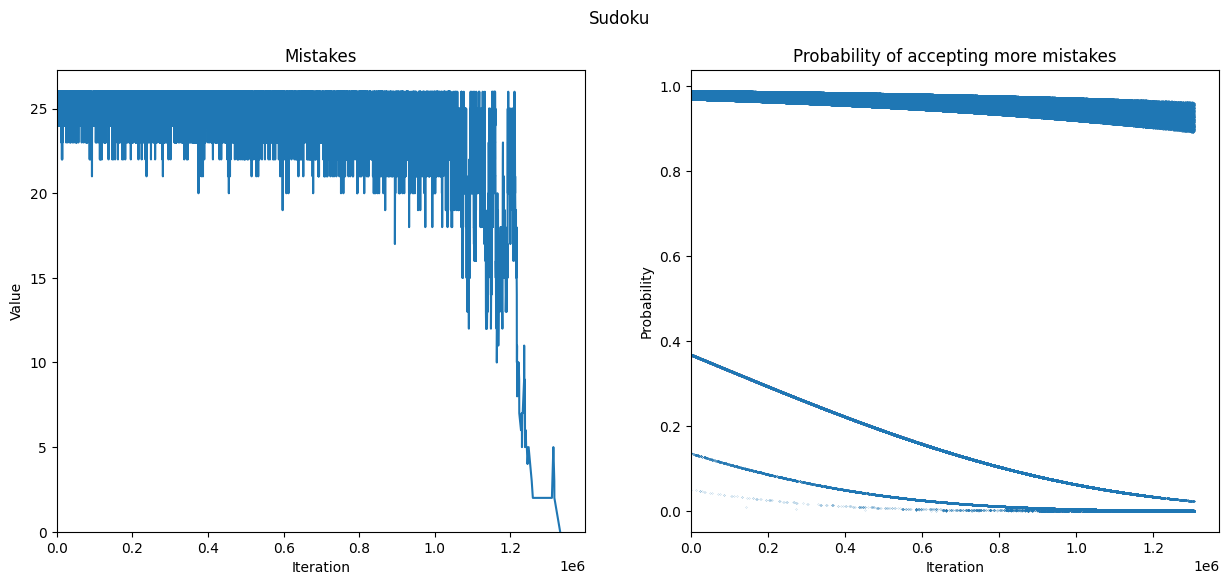

In [48]:
it, empty = draw_sudoku_plots("sudoku", 1, 0.999999)

Number of mistakes:  2
[1 5 9 2 8 6 3 4 7]
[8 2 6 3 7 9 5 4 1]
[7 4 3 2 5 1 9 8 6]
[6 1 8 5 9 7 4 2 3]
[4 9 7 6 2 3 1 5 8]
[5 3 2 8 1 4 6 7 9]
[2 6 1 7 4 8 3 9 5]
[9 7 4 1 3 5 6 8 2]
[3 8 5 9 6 2 1 7 4]


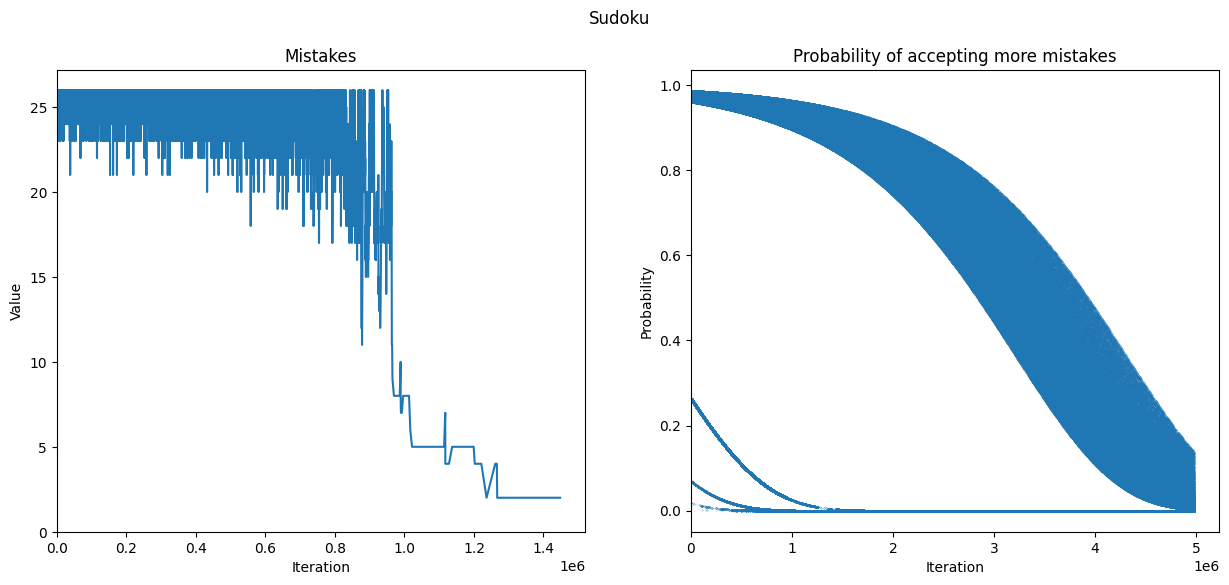

In [42]:
it1, empty1 = draw_sudoku_plots("sudoku1", 0.75, 0.999999)

Number of mistakes:  0
[4 3 5 2 6 9 7 8 1]
[6 8 2 5 7 1 4 9 3]
[1 9 7 8 3 4 5 6 2]
[8 2 6 1 9 5 3 4 7]
[3 7 4 6 8 2 9 1 5]
[9 5 1 7 4 3 6 2 8]
[5 1 9 3 2 6 8 7 4]
[2 4 8 9 5 7 1 3 6]
[7 6 3 4 1 8 2 5 9]


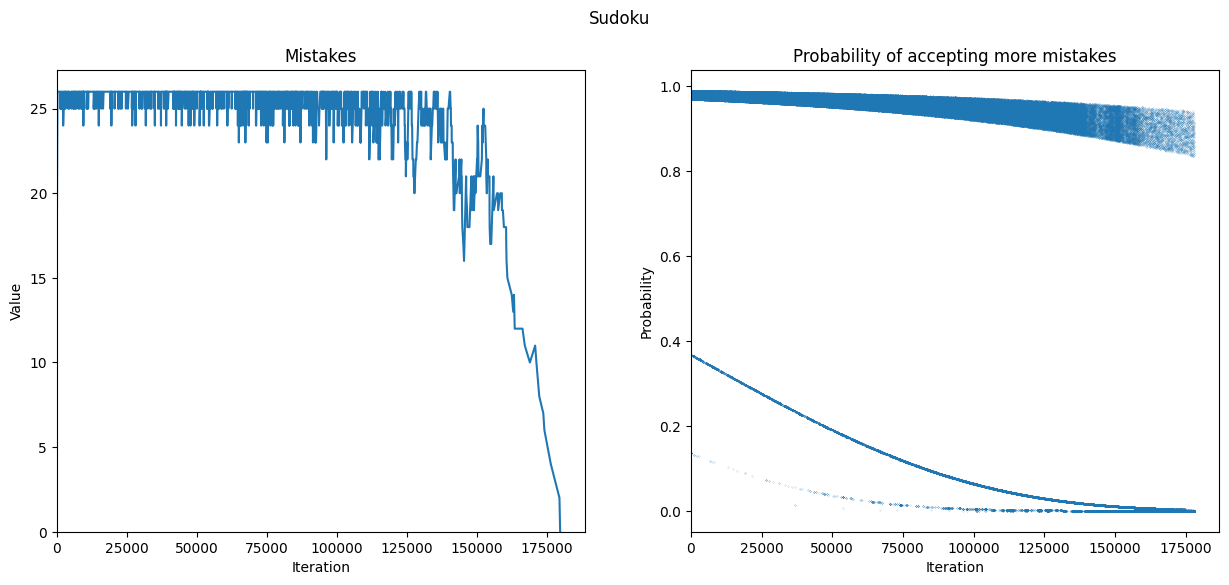

In [43]:
it2, empty2 = draw_sudoku_plots("sudoku2", 1, 0.99999)

Number of mistakes:  3
[5 6 8 7 2 4 9 1 3]
[1 9 7 3 8 6 2 5 4]
[3 4 2 1 5 9 6 8 7]
[6 1 1 4 7 8 5 3 2]
[7 3 4 9 2 5 1 6 8]
[2 8 5 6 3 1 4 7 9]
[9 2 6 3 1 8 7 4 5]
[4 7 3 6 5 2 8 9 1]
[8 5 9 9 4 7 3 2 6]


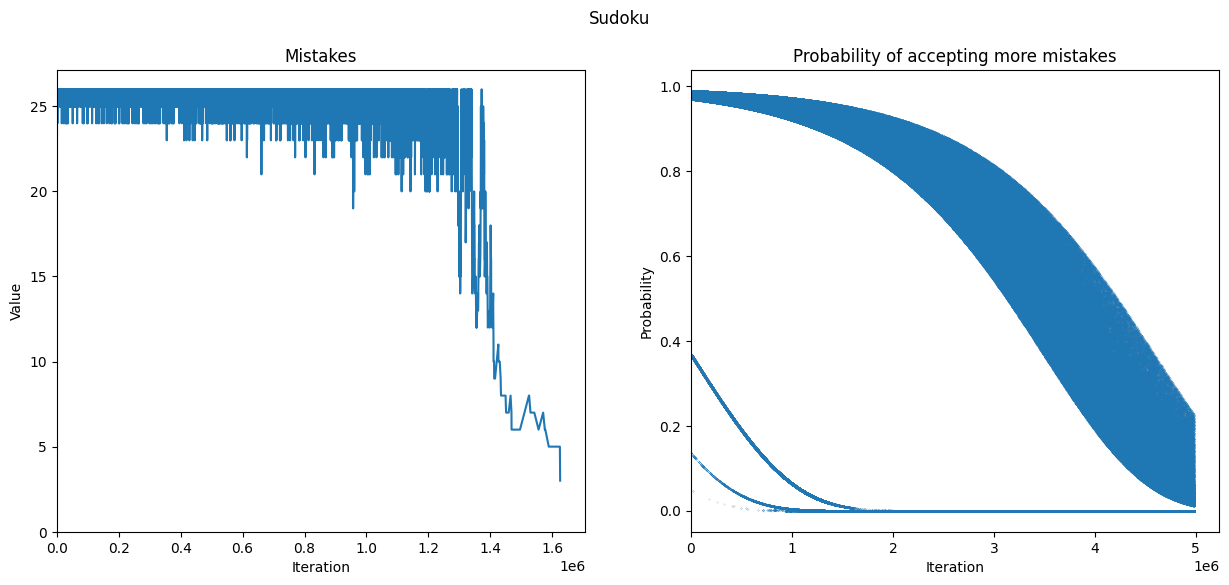

In [44]:
it3, empty3 = draw_sudoku_plots("sudoku3", 1, 0.999999)

Wykres liczby iteracji od liczby wystąpień x w sudoku. Wykres wydaje się nie przestawiać żadnej zależności, należy jednak pamiętać, że liczba iteracji zależy on hiperparametrów wyżarzania oraz szczęścia. Intuicja i podstawy kominatoryki podpowiadają jednak, że wykres powinien być ściśle rosnący.

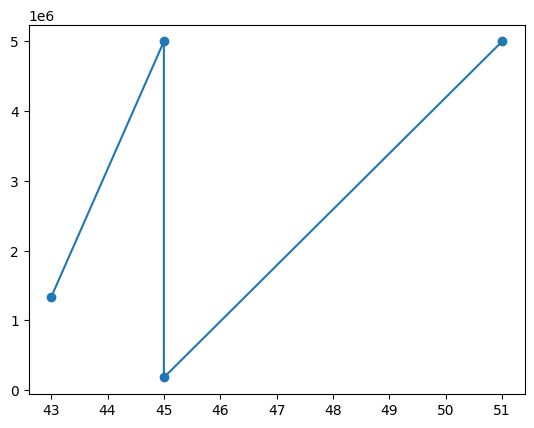

In [50]:
plt.plot([empty, empty1, empty2, empty3], [it, it1, it2, it3], "-o")